In [5]:
import sys
sys.path.append("/home/michael/Synology/Desktop/Data/Python/NeuralODE/DDFA_NODE")
import glob
import numpy as np
import pandas as pd
import time
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import src as ddfa_node

while True:
    losses = []
    iters = []

    files = glob.glob("/home/michael/Synology/Python/Gait-Signatures/ray_results/pb2_lovelace/**/progress.csv", recursive=True)
    for file in files:
        df = pd.read_csv(file)
        max_iterations = df["training_iteration"].max()
        if max_iterations >= 5:
            selected_rows = df[df.apply(lambda row: row["training_iteration"] == max_iterations, axis=1)]

            losses.append(selected_rows["total_val_loss"].max())
            iters.append(max_iterations)
    losses = np.abs(losses)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].hist(losses[losses < 0.5],bins=10)
    ax[0].set_xlabel("Loss")
    ax[0].set_ylabel("Count")
    ax[0].set_xlim([0, 0.6])

    ax[1].hist(np.abs(iters),bins=10)
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()
    display.clear_output(wait=True)
    time.sleep(30)
    

KeyboardInterrupt: 

In [6]:
glob.glob(files[np.argmax(losses)][:-12])

ValueError: attempt to get argmax of an empty sequence

## Import packages and set environment variables

In [1]:
import os
# os.environ["R_HOME"] = "/home/michael/anaconda3/envs/torch/lib/R"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import src as ddfa_node
import matplotlib.pyplot as plt
import importlib
import torch
importlib.reload(ddfa_node)
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%matplotlib inline

## Load and prepare data

In [2]:
import numpy as np
data = np.load("/home/michael/Synology/Desktop/Data/Julia/data/VDP_SDEs.npy")
data.shape

(100, 5000, 2)

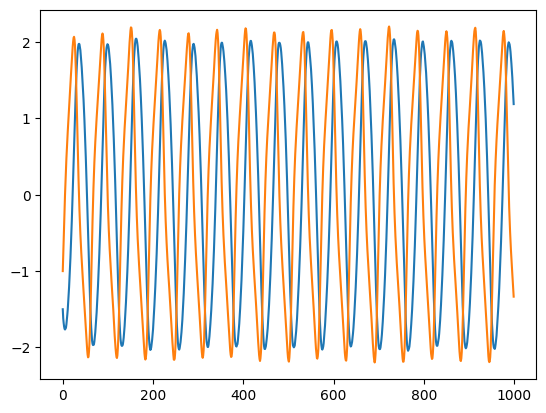

In [4]:
import matplotlib.pyplot as plt
plt.plot(data[0, :1000])

In [229]:
data_path = "/home/michael/Synology/Julia/data/human_data.npy"
data = ddfa_node.load_data_normalize(6, '/home/michael/Synology/Julia/data/human_data.npy')

In [231]:
np.save("/home/michael/Synology/Julia/data/human_data_TDE.npy", time_delayed_data)

[2.27373675e-17 1.49213975e-17]


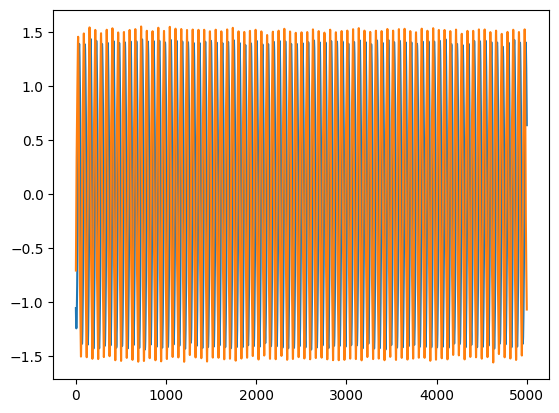

In [232]:
from scipy import stats
data = stats.zscore(np.load("/home/michael/Synology/Julia/data/VDP_SDEs.npy"), axis=1)
dimension_axis = 1

# Apply z-scoring along the dimensions axis
zscored_data = np.apply_along_axis(stats.zscore, dimension_axis, data)
print(zscored_data[0].mean(axis=0))
plt.plot(zscored_data[0])
plt.show()

## Taken's Embed the data with optimal parameters

In [113]:
zscored_data.shape

(100, 5000, 2)

In [233]:
time_delayed_data, k, τ = ddfa_node.embed_data(zscored_data[:, 1000:-1:2, :], maxlags=np.inf)
# time_delayed_data, k, τ = ddfa_node.embed_data(data, maxlags=np.inf)

# τ, k = 19, 5
# time_delayed_data = ddfa_node.takens_embedding(data, τ, k)

6
Data has been embedded using a delay of 6 timesteps and an embedding dimension of 4


## Train models

In [234]:
np.save("/home/michael/Synology/Julia/data/VDP_data_TDE.npy", time_delayed_data)

In [224]:
features, timesteps, samples

torch.Size([7500, 500, 10])

In [124]:
import h5py
hf = h5py.File('data/van_der_pol.h5', 'w')
hf.create_dataset('training/high_dim_data', data=data_train.detach().cpu())
hf.create_dataset('validation/high_dim_data', data=data_val.detach().cpu())
hf.close()

In [116]:
data_train.shape, data_val.shape

(torch.Size([7500, 500, 10]), torch.Size([2500, 500, 10]))

In [127]:
func.nfe

55328723

In [115]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Subsample whole trials to smaller ones
timesteps_per_sample = 500
data = ddfa_node.change_trial_length(time_delayed_data, timesteps_per_subsample=timesteps_per_sample, skip=30)

# Train/test splitting
train_size = 0.5
data_train, data_val = ddfa_node.split_data(data, train_size=train_size)

# Add noise to data
noise_std = 0.1
data_train = ddfa_node.augment_data_with_noise(data_train, n_copies=3, noise_std=noise_std)

data_train, data_val = torch.from_numpy(data_train).float().to(device), torch.from_numpy(data_val).float().to(device)

In [84]:
ts_num = 5.0
tot_num = data_train.shape[1]

samp_ts = np.linspace(0, ts_num, num=tot_num)
samp_ts = torch.from_numpy(samp_ts).float().to(device)

val_num = ts_num / tot_num * data_val.shape[1]
val_ts = np.linspace(0, val_num, data_val.shape[1])
val_ts = torch.from_numpy(val_ts).float().to(device)

In [91]:
batch_size = 64
latent_dim = 16
n_hidden = 64
dec_hidden = 16
obs_dim = data_train.shape[-1]
rnn_hidden = 256
n_itrs = 2000
lr = 1e-4
dropout = 0.25
alpha = 1e-5

In [92]:
# train from scratch:
func, rec, dec, train_losses, val_losses, val_mses = ddfa_node.train_network(data_train=data_train, data_val=data_val, device=device, samp_ts=samp_ts, val_ts=val_ts, n_itrs=n_itrs, latent_dim=latent_dim, n_hidden=n_hidden, obs_dim=obs_dim, rnn_hidden=rnn_hidden, dec_hidden=dec_hidden, batch_size=batch_size, lr=lr, dropout=dropout, noise_std=noise_std, alpha=alpha)

Iter: 0, total loss: 3.5078299045562744, kl_loss: 2.4858648437500004, mse_loss: 1.0219650268554688 val loss: 3.4687821865081787, val_kl: 2.4579740625000004, val_mse: 1.0108082294464111
Iter: 5, total loss: 3.4708333015441895, kl_loss: 2.4595100000000003, mse_loss: 1.0113235712051392 val loss: 3.4378554821014404, val_kl: 2.4359540625, val_mse: 1.001901388168335
Iter: 10, total loss: 3.4743218421936035, kl_loss: 2.4620173437500004, mse_loss: 1.012304425239563 val loss: 3.492401599884033, val_kl: 2.4749320312500003, val_mse: 1.0174696445465088
Iter: 15, total loss: 3.490617275238037, kl_loss: 2.4736659375000003, mse_loss: 1.0169514417648315 val loss: 3.4229516983032227, val_kl: 2.4253334375000004, val_mse: 0.9976183176040649
Iter: 20, total loss: 3.4665236473083496, kl_loss: 2.4564851562500003, mse_loss: 1.0100384950637817 val loss: 3.4353716373443604, val_kl: 2.43423375, val_mse: 1.0011379718780518
Iter: 25, total loss: 3.429011821746826, kl_loss: 2.42972, mse_loss: 0.9992919564247131 va

In [ ]:
# further train existing model
(func, rec, dec), (train_losses, val_losses, val_mses) = ddfa_node.train_network(func=func, rec=rec, dec=dec, data_train=data_train, data_val=data_val, device=device, samp_ts=samp_ts, val_ts=val_ts, n_itrs=n_itrs, latent_dim=latent_dim, n_hidden=n_hidden, obs_dim=obs_dim, rnn_hidden=rnn_hidden, dec_hidden=dec_hidden, batch_size=batch_size, lr=lr, dropout=dropout, noise_std=noise_std, alpha=alpha)

In [29]:
## Evaluate model

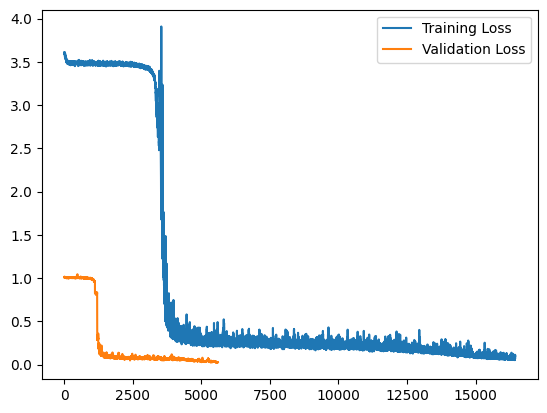

In [93]:
%matplotlib inline

plt.plot(train_losses, label="Training Loss")
plt.plot(val_mses, label="Validation Loss")
plt.legend()
plt.show()

In [19]:
all_data.shape[0]

72

In [155]:
func.nfe = 0

In [197]:
import torch.nn as nn
rec.dropout = nn.Dropout(0.0)
dec.dropout = nn.Dropout(0.0)

In [164]:
func.noise = ddfa_node.latent_neural_ode_model.GaussianNoise(0.1)

In [214]:
%matplotlib inline
from torchdiffeq import odeint

window_size_multiplier = 200
new_data_size = timesteps_per_sample*window_size_multiplier
dt = np.diff(samp_ts.cpu())[0] / 50
new_ts = np.arange(0, new_data_size*dt, step=dt)
new_ts = torch.from_numpy(new_ts).float().to(device)

all_data = torch.from_numpy(time_delayed_data[:, :timesteps_per_sample, :]).float().to(device)

h = torch.zeros(1, all_data.shape[0], rnn_hidden).to(device)
c = torch.zeros(1, all_data.shape[0], rnn_hidden).to(device)

hn = h[0, :, :]
cn = c[0, :, :]

with torch.no_grad():
    for t in reversed(range(all_data.shape[1])):
        obs = all_data[:, t, :]
        out, hn, cn = rec.forward(obs, hn, cn)
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
    # z0 += torch.randn(*z0.shape, device=device) * 0.6

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, new_ts, method='euler').permute(1, 0, 2) #change time and batch with permute
    pred_x = dec(pred_z)

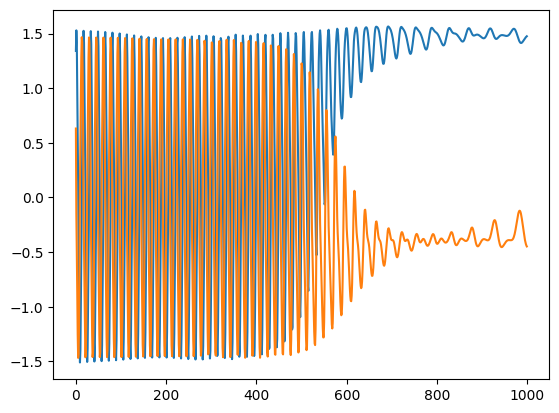

In [221]:
plt.plot(pred_x[0, ::100, ::k+1].detach().cpu())
# plt.plot(time_delayed_data[18, :new_data_size, ::k+1])

In [213]:
np.save("data/VDP_gen_data.npy", pred_x[:, 0:25000:10, :].detach().cpu())

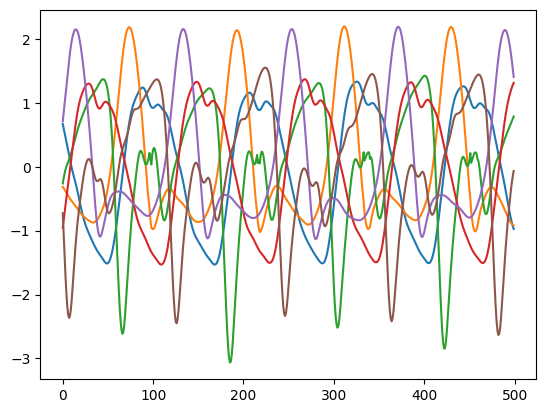

In [39]:
plt.plot(time_delayed_data[0, :timesteps_per_sample, ::k+1])
plt.show()

In [ ]:
metrics = model.evaluate()

## Get self-driven data

In [ ]:
self_generated_data = ddfa_node.generate_data_from_model(model, steps=5000)

## Estimate Floquet multipliers

In [ ]:
λs = ddfa_node.get_FM(self_generated_data)

## Visualize Floquet multipliers

In [ ]:
ddfa_node.make_FM_plots(λs)